# Dataset Proposal v.1.1

In [2]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime as dt
from itertools import count
%matplotlib inline
# to rotate 3D plot interactively
%matplotlib notebook
# Test if coordinates.csv is correct

def get_path():
    Path = 'Dataset_Proposal/coordinates_yz.csv'
    return Path

def get_coords():
    Path = get_path()
    csv_df = pd.read_csv(Path,header=None) # ,header=None
    csv_np = csv_df.to_numpy()
    # center of gravity
    cogs = np.expand_dims(csv_np[:,0:3],axis=1)
    # coordinates of all joints
    x_coord = np.expand_dims(csv_np[:,3::3], axis=1)
    y_coord = np.expand_dims(csv_np[:,4::3], axis=1)
    z_coord = np.expand_dims(csv_np[:,5::3], axis=1)
    coords = np.concatenate((x_coord,y_coord,z_coord), axis=1)
    return coords,cogs

coords,cogs = get_coords()
print(f'Coordinates shape: {coords.shape}')
print(f'Center of gravity shape: {cogs.shape}')

Coordinates shape: (18000, 3, 26)
Center of gravity shape: (18000, 1, 3)


## 1. Input original data from coordinates.csv and test if data is correct
<font size=2>
  
The **coordinates.csv** is generated from **MCS_chart.ipynb** after selecting recognizable data. Note that the original unit from Unknown.csv was **mm**, but the extracted data into **coordinates.csv** has already been transferred into **m**.
    
Here are indices and corresponding joints in each coordinate-array (i.e.x_coord,y_coord,z_coord), **after** eliminating columns of **center of gravity**:
    
    0:LWrist 1:LElbow 2:LShoulder
    3:RWrist 4:RElbow 5:RShoulder
    6:LToe 7:LAnkle 8:LKnee 9:LHip
    10:RToe 11:RAnkle 12:RKnee 13:RHip
    14:LClavicle 15:LHandEnd 16:LToesEnd
    17:RClavicle 18:RHandEnd 19:RToesEnd
    20:spine1 21:spine2 22:spine3 23:spine4 24:spine5 25:head 
    
</font>

#### 1.1 Plot to check dataset

In [3]:
#######################################
###### connect joints with links ######
#######################################

def get_links_dict():
    links_dict = {'left arm': [15,0,1,2,14,24],
                  'right arm': [18,3,4,5,17,24],
                  'left leg': [16,6,7,8,9,20],
                  'right leg': [19,10,11,12,13,20],
                  'spine': [20,21,22,23,24,25]
                 }
    return links_dict

def connect(frame,ax,joints):
    idx_lst = [[],[],[]]
    for i in joints:
        idx_lst[0].append(frame[0,i])
        idx_lst[1].append(frame[1,i])
        idx_lst[2].append(frame[2,i])
        ax.plot(idx_lst[0], idx_lst[1], idx_lst[2], color='red')

def connect_with_lines(frame,ax,links_dict):
    for link_name,joints in links_dict.items():
        connect(frame,ax,joints)

##################
###### plot ######
##################

def calc_axis_limit(coords):
    x_high, x_low = int(np.ceil(coords[:,0,:].max()*1000/200.0))*200, int(np.floor(coords[:,0,:].min()*1000/200.0))*200
    y_high, y_low = int(np.ceil(coords[:,1,:].max()*1000/200.0))*200, int(np.floor(coords[:,1,:].min()*1000/200.0))*200
    z_high, z_low = int(np.ceil(coords[:,2,:].max()*1000/200.0))*200, int(np.floor(coords[:,2,:].min()*1000/200.0))*200
    return [[x_high, x_low],[y_high, y_low],[z_high, z_low]]

def prepare_ax(coords,ax,limits):
    # axis label
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # axis limit
    x_high, x_low = limits[0][0],limits[0][1]
    y_high, y_low = limits[1][0],limits[1][1]
    z_high, z_low = limits[2][0],limits[2][1]
    ax.axes.set_xlim3d(left=x_low/1000.0, right=x_high/1000.0) 
    ax.axes.set_ylim3d(bottom=y_low/1000.0, top=y_high/1000.0)
    ax.axes.set_zlim3d(bottom=z_low/1000.0, top=z_high/1000.0)
    # axis scale
    ax.set_xticks(list(i/1000.0 for i in range(x_low,x_high,200)))
    ax.set_yticks(list(i/1000.0 for i in range(y_low,y_high,200)))
    ax.set_zticks(list(i/1000.0 for i in range(z_low,z_high,200)))
    # axis aspect ratio
    ax.set_box_aspect(aspect = (x_high-x_low,y_high-y_low,z_high-z_low))
    
def plot_func(frame_id,ax,coords,links_dict,limits,title):
    # plot links in 3D 
    ax.cla()
    current_frame = coords[frame_id]
    prepare_ax(coords,ax,limits)
    ax.set_title(title)
    ax.scatter3D(current_frame[0], current_frame[1], current_frame[2], c='steelblue', marker='<')
    connect_with_lines(current_frame,ax,links_dict)

<IPython.core.display.Javascript object>


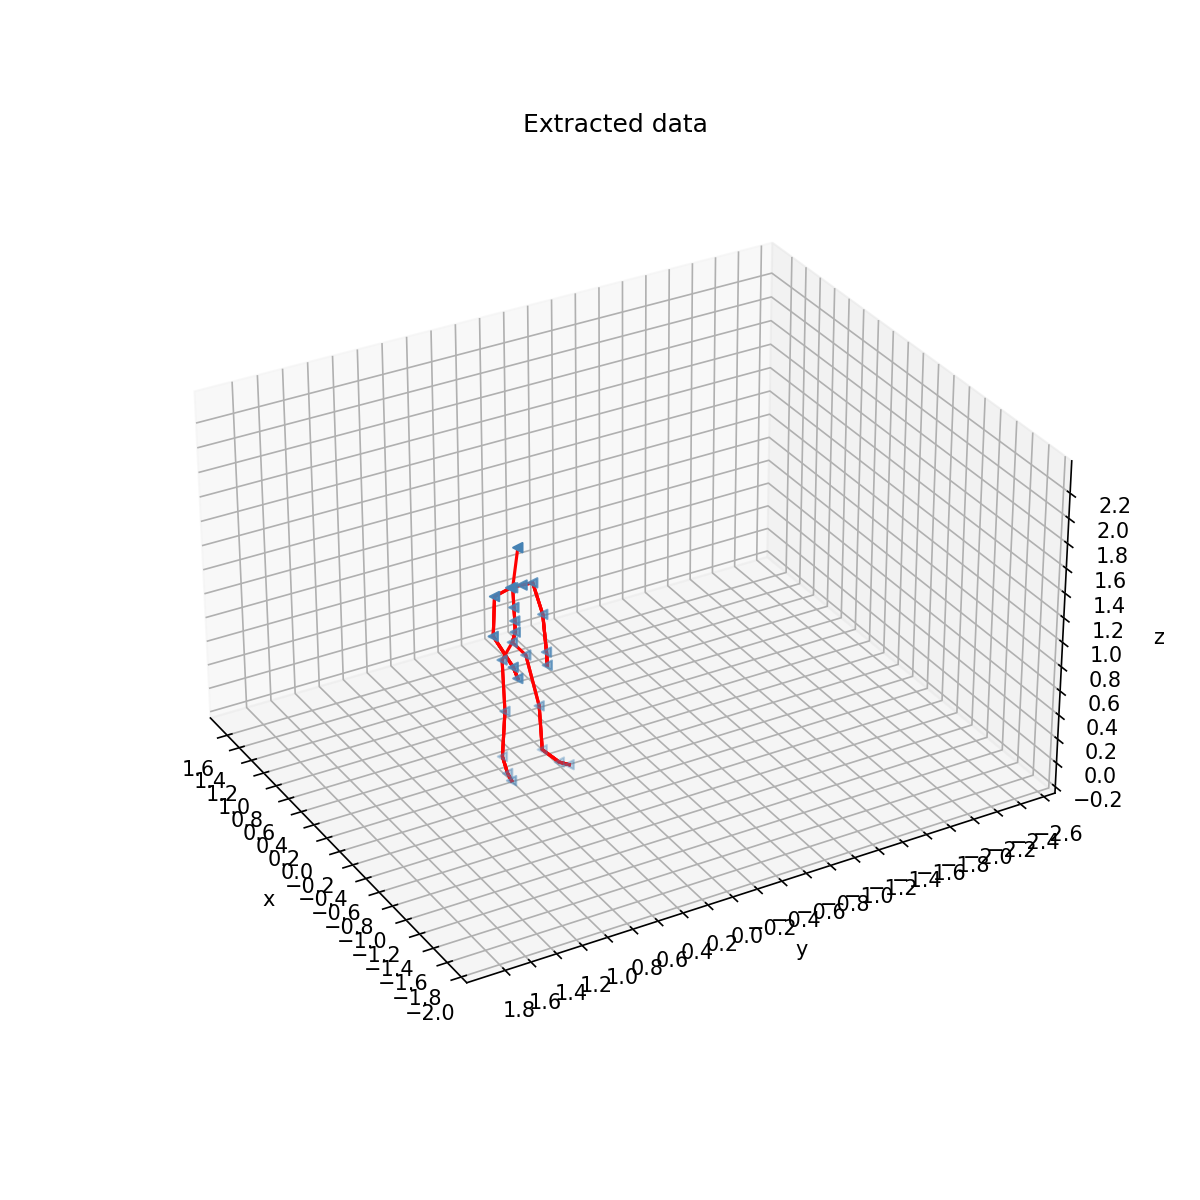

In [4]:
coords,_ = get_coords()
start_frame = 0
end_frame = 18000
coords = coords[start_frame:end_frame]
# coords = coords[6000:]
links_dict = get_links_dict()
N_frames = end_frame - start_frame
limits1 = calc_axis_limit(coords) # (x_high, x_low), (y_high, y_low), (z_high, z_low)
title1 = 'Extracted data'

fig = plt.figure(figsize=(8,8))
fig.tight_layout()
ax1 = fig.add_subplot(projection='3d')
ax1.view_init(30, 150)

ani = animation.FuncAnimation(fig,plot_func,frames=N_frames,fargs=(ax1,coords,links_dict,limits1,title1),interval=17)
plt.show()

## 2. Distance features

#### 2.1 Calculation of all distances
<font size=2>
    
Calculate distances between every 2 joints and save in a 2D array. E.g. there are 26 joints, then the distance-array has shape [26,26], each element [i,j] represents the distance between **joint i** and **joint j**.
    
</font>

In [5]:
def get_joint_index():
    joint_index_dict = {'LWrist':0, 'LElbow':1, 'LShoulder':2,
                       'RWrist':3, 'RElbow':4, 'RShoulder':5,
                       'LToe':6, 'LAnkle':7, 'LKnee':8, 'LHip':9,
                       'RToe':10, 'RAnkle':11, 'RKnee':12, 'RHip':13,
                       'LClavicle':14, 'LHandEnd':15, 'LToesEnd':16,
                       'RClavicle':17, 'RHandEnd':18, 'RToesEnd':19,
                       'spine1':20, 'spine2':21, 'spine3':22, 'spine4':23, 'spine5':24, 'head':25
                      }
    return joint_index_dict

def calc_all_distances():
    # e,g, dist_feature[3,1,4] means distance between LElbow and RElbow in 3rd frame
    coords,_ = get_coords() # coords: [frames,xyz,num_joints] = [18000,3,26]
    num_frame, num_joints = coords[:,0,:].shape
    all_distances = np.zeros((num_frame,num_joints,num_joints))
    new_coords = np.expand_dims(coords, axis=-2) # shape [18000,3,26] -> [18000,3,1,26]
    # calculate dis_feature:
    #     diff = coords - transpose(coords,(0,1,3,2)):
    #       meaning: x-x.T, y-y.T, z-z.T
    #       shape: [18000,3,1,26] - [18000,3,26,1] = [18000,3,26,26]
    #     sum(diff**2,axis=1):
    #       meaning: (x-x.T)**2 + (y-y.T)**2 + (z-z.T)**2
    #       shape: [18000,3,26,26] -> [18000,26,26]
    all_distances = np.sqrt(np.sum((new_coords - np.transpose(new_coords,(0,1,3,2)))**2,axis=1))
    return all_distances

all_distances = calc_all_distances()
print(f'all_distances shape: {all_distances.shape}')

all_distances shape: (18000, 26, 26)


#### 2.2 Examine whether distances are calculated correctly
<font size=2>
    
From 2.1, an array with shape [600,26,26] is obtained, which means there are 600 frames, in each frame there are distances between random 2 joints (from all 26 joints).
    
Below is the way to examine whether the array fulfills the expectation, i.e. whether the array truely contains information of distances.
    
</font>

In [6]:
def examine_distance(frame, joint_1, joint_2):
    coords,_ = get_coords()
    all_distances = calc_all_distances()
    joint_index_dict = get_joint_index()
    joint_1_idx = joint_index_dict[joint_1]
    joint_2_idx = joint_index_dict[joint_2]
    dist_from_array = all_distances[frame,joint_1_idx,joint_2_idx]
    dist_calculated = np.sqrt((coords[frame,0,joint_1_idx] - coords[frame,0,joint_2_idx])**2 
                        + (coords[frame,1,joint_1_idx] - coords[frame,1,joint_2_idx])**2 
                        + (coords[frame,2,joint_1_idx] - coords[frame,2,joint_2_idx])**2
                       )
    print(f'distance indexed from distances array: {dist_from_array}')
    print(f'distance calculated from coordinates: {dist_calculated}')
    print(f'wehther the same: {dist_from_array == dist_calculated}')

frame = 17650
joint_1 = 'RHandEnd'
joint_2 = 'spine3'
examine_distance(frame, joint_1, joint_2)

distance indexed from distances array: 0.5014906603134003
distance calculated from coordinates: 0.5014906603134003
wehther the same: True


#### 2.3 Select distance feature
<font size=2>
    
Edit the dictionary **desired_dist_lst** following the example
    
</font>

In [7]:
def get_dist_feature(desired_dists):
    all_distances = calc_all_distances()
    joint_index_dict = get_joint_index()
    dist_feature = np.zeros((all_distances.shape[0],len(desired_dists)))
    for idx,desired_dist in enumerate(desired_dists):
        joint1,joint2 = desired_dist.split('_')
#         print(f'joint1: {joint1}, joint2: {joint2}')
        dist_feature[:,idx] = all_distances[:,joint_index_dict[joint1],joint_index_dict[joint2]]
    return dist_feature

def get_desired_dist_lst():
    """
    e.g. edit the desired_dists as example here: ['LWrist_head','LElbow_head']
    and 'LWrist_head' means the distance between LWrist and head
    """
    desired_dists = ['LHandEnd_head','LWrist_head','LElbow_head','LShoulder_head',
                     'RHandEnd_head','RWrist_head','RElbow_head','RShoulder_head',
                     'LHandEnd_spine5','LWrist_spine5','LElbow_spine5','LShoulder_spine5',
                     'RHandEnd_spine5','RWrist_spine5','RElbow_spine5','RShoulder_spine5',
                     'LHandEnd_spine4','LWrist_spine4','LElbow_spine4','LShoulder_spine4',
                     'RHandEnd_spine4','RWrist_spine4','RElbow_spine4','RShoulder_spine4']
    return desired_dists
dist_feature = get_dist_feature(get_desired_dist_lst())
print(f'dist_feature shape: {dist_feature.shape}')
print(f'dist_feature[0]: {dist_feature[0]}')

dist_feature shape: (18000, 24)
dist_feature[0]: [0.9996285  0.90691245 0.68082046 0.39121242 0.98379053 0.89109971
 0.6721485  0.37789744 0.66966518 0.58087793 0.37282138 0.18222381
 0.65880494 0.56719052 0.36799961 0.15766484 0.52772281 0.44409208
 0.2775523  0.2409751  0.51591343 0.42782484 0.27043224 0.22030367]


### 3. Calculation of angles
<font size=2>
    
Calculate angles between every 2 adjacent links and save in a np.array with shape [num_frames,num_angles]. E.g. [430,2]=2.18274673 represents the angle between link **LElbow_LShoulder** and link **LShoulder_LClavicle** is 2.18274673, in radian.
    
Indices of joints is below:
    
    0:LWrist 1:LElbow 2:LShoulder
    3:RWrist 4:RElbow 5:RShoulder
    6:LToe 7:LAnkle 8:LKnee 9:LHip
    10:RToe 11:RAnkle 12:RKnee 13:RHip
    14:LClavicle 15:LHandEnd 16:LToesEnd
    17:RClavicle 18:RHandEnd 19:RToesEnd
    20:spine1 21:spine2 22:spine3 23:spine4 24:spine5 25:head 
    
The relation and order among joints is below:
    
    index 15,0,1,2,14,24: left arm
    index 18,3,4,5,17,24: right arm
    index 16,6,7,8,9,20: left leg
    index 19,10,11,12,13,20: right leg
    index 20,21,22,23,24,25: spine

Given edges $a$,$b$,$c$ of a triangle, and the task is to calculate the angle $B$ which is opposite to edge $b$, use the following formular:
    
$$
\begin{equation}
\begin{aligned}
cos(B) &= \frac{c^{2} + a^{2} - b^{2}}{2ac} \\
B &= arccos(cos(B))
\end{aligned}
\end{equation}
$$
    
</font>

In [8]:
def get_angle_pairs(desized_angles):
    angle_pairs_dict = {}
    all_angle_pairs_dict = {'LHandEnd_LWrist_LElbow':[15,0,1],
                        'LWrist_LElbow_LShoulder':[0,1,2],
                        'LElbow_LShoulder_LClavicle':[1,2,14],
                        'LShoulder_LClavicle_spine5':[2,14,24],
                        'LClavicle_spine5_spine4':[14,24,23],
                        'LClavicle_spine5_head':[14,24,25],
                        'RHandEnd_RWrist_RElbow':[18,3,4],
                        'RWrist_RElbow_RShoulder':[3,4,5],
                        'RElbow_RShoulder_RClavicle':[4,5,17],
                        'RShoulder_RClavicle_spine5':[5,17,24],
                        'RClavicle_spine5_spine4':[17,24,23],
                        'RClavicle_spine5_head':[17,24,25],
                        'LClavicle_spine5_RClavicle':[14,24,17],
                        'LToesEnd_LToe_LAnkle':[16,6,7],
                        'LToe_LAnkle_LKnee':[6,7,8],
                        'LAnkle_LKnee_LHip':[7,8,9],
                        'LKnee_LHip_spine1':[8,9,20],
                        'RToesEnd_RToe_RAnkle':[19,10,11],
                        'RToe_RAnkle_RKnee':[10,11,12],
                        'RAnkle_RKnee_RHip':[11,12,13],
                        'RKnee_RHip_spine1':[12,13,20],
                        'LHip_spine1_RHip':[9,20,13],
                        'LHip_spine1_spine2':[9,20,21],
                        'RHip_spine1_spine2':[13,20,21],
                        'spine1_spine2_spine3':[20,21,22],
                        'spine2_spine3_spine4':[21,22,23],
                        'spine3_spine4_spine5':[22,23,24],
                        'spine4_spine5_head':[23,24,25]
                       }
    for desired_angle in desized_angles:
        if not all_angle_pairs_dict.get(desired_angle) == None:
            angle_pairs_dict[desired_angle] = all_angle_pairs_dict[desired_angle]
    return angle_pairs_dict

def calc_angles(joints_lst,distances):
    # b: the edge in triangle ABC which is opposite to the angle to be calculated
    # a,c: side edges
    # refer to formular: 
    # https://www.mathsisfun.com/algebra/trig-cosine-law.html
    a = distances[joints_lst[0],joints_lst[1]]
    b = distances[joints_lst[0],joints_lst[2]]
    c = distances[joints_lst[1],joints_lst[2]]
    cos_b = (c**2 + a**2 - b**2) / (2*c*a)
    B = np.arccos(cos_b) # radius = np.arccos(cos_value)
    return B

def get_angle_feature(desized_angles):
    all_distances = calc_all_distances()
    angle_pairs_dict = get_angle_pairs(desized_angles)
#     print(f'desired angles are: {angle_pairs_dict}')
    num_frames = all_distances.shape[0]
    num_angles = len(angle_pairs_dict)
    angle_feature = np.zeros((num_frames,num_angles))
    for frame, distances in enumerate(all_distances):
        for angle_idx, (angle_name,joints_lst) in enumerate(angle_pairs_dict.items()):
            angle_feature[frame,angle_idx] = calc_angles(joints_lst,distances)
    return angle_feature

def get_desized_angles():
    desized_angles = ['LHandEnd_LWrist_LElbow',
                      'LWrist_LElbow_LShoulder',
                      'LElbow_LShoulder_LClavicle',
                      'LShoulder_LClavicle_spine5',
                      'LClavicle_spine5_spine4',
                      'LClavicle_spine5_head',
                      'RHandEnd_RWrist_RElbow',
                      'RWrist_RElbow_RShoulder',
                      'RElbow_RShoulder_RClavicle',
                      'RShoulder_RClavicle_spine5',
                      'RClavicle_spine5_spine4',
                      'RClavicle_spine5_head',
                      'spine3_spine4_spine5',
                      'spine4_spine5_head'
                     ]
    return desized_angles
angle_feature = get_angle_feature(get_desized_angles())
print(f'angle_feature has shape: {angle_feature.shape}')

angle_feature has shape: (18000, 14)


## 4. Calculate coordinates in cog-frame
<font size=2>

For example, when holding hands close to body and holding hands away from body, the absolute angles Elbow_Shoulder_Clavicle (no matter left or right) might be both close to 90°, but obviously the direction of them are different. So more action should be done to make sure these are different situations.

One of the solutions is to consider vector between random joint and a base joint. E.g. the vector between LElbow and spine4, where spine4 is base joint. However, such vectors still vary along with absolute spacial movement. In order to get rid of influence of absolute spacial movement, only leave the part from relative movement, all coordinates need to be transferred into new coordinate frame, e.g. the ones taking Cog as origins for each frame.
    
Then next steps are:
    
1) Calculate transformation matrix of each frame, from absolute world frame to cog frame
    
2) Transfer all coordinates into new frame
    
</font>

#### 4.1 Calculate transformation matrix $T$
<font size=2>
    
In order to get transformation matrix $T$, next steps would be followed:
    
1) Determine a normal direction vector of body, which should always point to frontal direction compared with body
    
2) Get row, pitch, yaw angles of this vector in absolute coordinate system, compared with origin [0,0,0]
    
3) Calculate transformation matrix $T$
    
</font>

In [176]:
def get_norm_vec():
    norm_vec = 0
    return norm_vec

def get_row_pitch_yaw():
    norm_vec = get_norm_vec()
    row = 0
    pitch = 0
    yaw = 0
    return row,pitch,yaw

def get_trans_matrix():
    row,pitch,yaw = get_row_pitch_yaw()
    T = 0
    return T

#### 4.2 Transfer all coordinates into new frame with transformation matrix $T$

In [177]:
def into_new_frame():
    coords,cogs = get_coords()
    pass

## 5. Feature selection
<font size=2>
    
Select the potentially important features from both distances and angles. There are 2 proposals:
    
1. Only select the ones defining the activities
    
For now we have prior knowledge that the activities are:
    
    hold hands near body
    hold hands away from body
    hands over head
    hold phone with left hand
    hold phone with right hand
    
And we also know that all of these activites are mainly defined by upper-body. All other suborinate activities are noises. The purpose is to focus on the activities we want to classify and classify them. So first proposal only contains the features defining the desired activities, neglecting others, and see if the machine learning model is able to classify.
    
2. Add noisy features
    
Add lower-body features and test if model can learn to give less weights on these noisy features and classify.
    
</font>

In [9]:
def generate_dataset(verify=False):
    # define desired distance features
    desired_dists = ['LHandEnd_head','LWrist_head','LElbow_head','LShoulder_head',
                     'RHandEnd_head','RWrist_head','RElbow_head','RShoulder_head',
                     'LHandEnd_spine5','LWrist_spine5','LElbow_spine5','LShoulder_spine5',
                     'RHandEnd_spine5','RWrist_spine5','RElbow_spine5','RShoulder_spine5',
                     'LHandEnd_spine4','LWrist_spine4','LElbow_spine4','LShoulder_spine4',
                     'RHandEnd_spine4','RWrist_spine4','RElbow_spine4','RShoulder_spine4']
    # define desired angle features
    desized_angles = ['LHandEnd_LWrist_LElbow',
                      'LWrist_LElbow_LShoulder',
                      'LElbow_LShoulder_LClavicle',
                      'LShoulder_LClavicle_spine5',
                      'LClavicle_spine5_spine4',
                      'LClavicle_spine5_head',
                      'RHandEnd_RWrist_RElbow',
                      'RWrist_RElbow_RShoulder',
                      'RElbow_RShoulder_RClavicle',
                      'RShoulder_RClavicle_spine5',
                      'RClavicle_spine5_spine4',
                      'RClavicle_spine5_head',
                      'spine3_spine4_spine5',
                      'spine4_spine5_head'
                     ]
    # get features
    dist_feature = get_dist_feature(desired_dists)
    angle_feature = get_angle_feature(desized_angles)
    dataset = np.concatenate((dist_feature, angle_feature), axis=1)

    if verify == False:
        return dataset
    else:
        return dataset,desired_dists,desized_angles

dataset = generate_dataset()
print(f'dataset has shape: {dataset.shape}')

dataset has shape: (18000, 38)


## 6. Dataset
#### 6.1 Create
<font size=2>
    
1. Cutting frames
    
There are 5 activities to be classified in original csv. Firstly clip out all frames containing ambiguous activities, such as transitional movement from one activity to another.
    
Here are the frames to remain:
    
    frames 200 - 3700, label 1: hold hands near body
    frames 3900 - 7200, label 2: hold hands away from body
    frames 7400 - 10700, label 3: hands over head
    frames 10900 - 14400, label 4: hold phone with left hand
    frames 14600 - 18000, label 5: hold phone with right hand
    
2. Label frames
    
Create another array with shape [num_frames,], whose values are labels for each frame. E.g. frame 300 belongs to activity **hold hands near body**, then value in index [300,] is **1**.
    
3. Output dataset

The output dataset will be 2 array, one is with shape [num_frame, 32] containing all selected features as input, the other is with shape [num_frame,] containing corresponding labels.
    
</font>

In [10]:
def output_dataset(output_npy=False):
    dataset = generate_dataset()
    x_data = np.concatenate((dataset[200:3700],
                            dataset[3900:7200],
                            dataset[7400:10700],
                            dataset[10900:14400],
                            dataset[14600:]),axis=0)
    y_data = np.concatenate((np.full((3700-200),1),
                            np.full((7200-3900),2),
                            np.full((10700-7400),3),
                            np.full((14400-10900),4),
                            np.full((18000-14600),5)),axis=0)
    if output_npy:
        record_path='./Dataset_Proposal'
        if not os.path.exists(record_path):
            os.mkdir(record_path)
        print(f'type: {type(x_data)}, shape: {x_data.shape}')
        np.save(os.path.join(record_path,'x_data.npy'), x_data)
        print(f'type: {type(y_data)}, shape: {y_data.shape}')
        np.save(os.path.join(record_path,'y_data.npy'), y_data)
    else:
        return [x_data,y_data]

x_data,y_data = output_dataset()
print(f'x_data:')
print(f'type: {type(x_data)}, shape: {x_data.shape}')
print()
print(f'y_data:')
print(f'type: {type(y_data)}, shape: {y_data.shape}')

x_data:
type: <class 'numpy.ndarray'>, shape: (17000, 38)

y_data:
type: <class 'numpy.ndarray'>, shape: (17000,)


#### 6.2 Verify
<font size=2>
    
Verify whether the frame and label match with each other.
    
PS:
    
Due to that the real features to output for training are only distances and angles, which is not as intuitive as skeletons, connect x_data and y_data to skeletons for visualization: label random frames in skeleton with labels from y_label, and compare calculated distances and angles from skeleton coordinates to x_data.
    
</font>

In [19]:
######################################
###### get verification dataset ######
######################################

def verification_dataset():
    dataset,desired_dists,desized_angles = generate_dataset(verify=True)
    coords,_ = get_coords()
    x_data = np.concatenate((dataset[200:3700],
                            dataset[3900:7200],
                            dataset[7400:10700],
                            dataset[10900:14400],
                            dataset[14600:]),axis=0)
    print(f'x_data shape: {x_data.shape}')
    y_data = np.concatenate((np.full((3700-200),1),
                            np.full((7200-3900),2),
                            np.full((10700-7400),3),
                            np.full((14400-10900),4),
                            np.full((18000-14600),5)),axis=0)
    print(f'y_data shape: {y_data.shape}')
    skeletons = np.concatenate((coords[200:3700],
                               coords[3900:7200],
                               coords[7400:10700],
                               coords[10900:14400],
                               coords[14600:]),axis=0)
    print(f'skeletons shape: {skeletons.shape}')
    return x_data,y_data,skeletons,desired_dists,desized_angles

##############################
###### verify distances ######
##############################

def calc_dist(skeleton,joint_1_idx,joint_2_idx):
    dist = np.sqrt((skeleton[0,joint_1_idx] - skeleton[0,joint_2_idx])**2 
                        + (skeleton[1,joint_1_idx] - skeleton[1,joint_2_idx])**2 
                        + (skeleton[2,joint_1_idx] - skeleton[2,joint_2_idx])**2
                       )
    return dist
    
def dist_equal_or_not(skeleton,dist_feature,desired_dists):
    joint_index_dict = get_joint_index()
    dist_equal_lst = []
    for idx,desired_dist in enumerate(desired_dists):
        dist_dataset = dist_feature[idx]
        joint1,joint2 = desired_dist.split('_')
        joint_1_idx = joint_index_dict[joint1]
        joint_2_idx = joint_index_dict[joint2]
        dist_skeleton = calc_dist(skeleton,joint_1_idx,joint_2_idx)
        dist_equal_lst.append(dist_dataset == dist_skeleton)
        if not dist_dataset == dist_skeleton:
            print(f'dist_dataset={dist_dataset},dist_skeleton={dist_skeleton}')
    return np.all(np.array(dist_equal_lst))

###########################
###### verify angles ######
###########################

def calc_angle(skeleton,joints_lst):
    # b: the edge in triangle ABC which is opposite to the angle to be calculated
    # a,c: side edges
    # refer to formular: 
    # https://www.mathsisfun.com/algebra/trig-cosine-law.html
    a = calc_dist(skeleton,joints_lst[0],joints_lst[1])
    b = calc_dist(skeleton,joints_lst[0],joints_lst[2])
    c = calc_dist(skeleton,joints_lst[1],joints_lst[2])
    cos_b = (c**2 + a**2 - b**2) / (2*c*a)
    B = np.arccos(cos_b) # radius = np.arccos(cos_value)
    return B

def angles_equal_or_not(skeleton,angle_feature,desized_angles):
    angle_pairs_dict = get_angle_pairs(desized_angles)
    angle_equal_lst = []
    for idx, (angle_name,joints_lst) in enumerate(angle_pairs_dict.items()):
        angle_dataset = angle_feature[idx]
        angle_skeleton = calc_angle(skeleton,joints_lst)
        angle_equal_lst.append(angle_dataset == angle_skeleton)
        if not angle_dataset == angle_skeleton:
            print(f'angle_dataset={angle_dataset},angle_skeleton={angle_skeleton}')
#     print(angle_equal_lst)
    return np.all(np.array(angle_equal_lst))

##########################
###### verification ######
##########################

def verification(dataset_path=None):
    if not dataset_path == None:
        x_data_path, y_data_path = dataset_path[0], dataset_path[1]
        with open(x_data_path, 'rb') as xf:
            x_data = np.load(xf)
        with open(y_data_path, 'rb') as yf:
            y_data = np.load(yf)
        _,_,skeletons,desired_dists,desized_angles = verification_dataset()
    else:
        x_data,y_data,skeletons,desired_dists,desized_angles = verification_dataset()
    # select random frames
    choices = np.random.randint(17000, size = 16)
    print(f'These frames will be verified: {choices}')
    # plot
    links_dict = get_links_dict()
    fig = plt.figure(figsize=(15,15))
    for idx,(frame,feature,label,skeleton) in enumerate(zip(choices,x_data[choices],y_data[choices],skeletons[choices])):
        # verify whether distances and angles are the same with dataset
        dist_equal = dist_equal_or_not(skeleton,feature[:len(desired_dists)],desired_dists)
        angles_equal = angles_equal_or_not(skeleton,feature[len(desired_dists):],desized_angles)
        # plot skeleton
        ax = fig.add_subplot(4, 4, idx+1, projection='3d')
        limits = calc_axis_limit(np.expand_dims(skeleton, axis=0))
        prepare_ax(np.expand_dims(skeleton, axis=0),ax,limits)
        ax.scatter3D(skeleton[0], skeleton[1], skeleton[2], c='steelblue', marker='<')
        connect_with_lines(skeleton,ax,links_dict)
        ax.set_title(f'label: {label}, dist: {dist_equal}, angles: {angles_equal}')
        ax.set_axis_off()
    fig.tight_layout()

x_data shape: (17000, 38)
y_data shape: (17000,)
skeletons shape: (17000, 3, 26)
These frames will be verified: [11134  5280  1010 14991  3603  9898  6190  3477 14248  3407 15069  9059
 14836  1273 12273 14151]


<IPython.core.display.Javascript object>


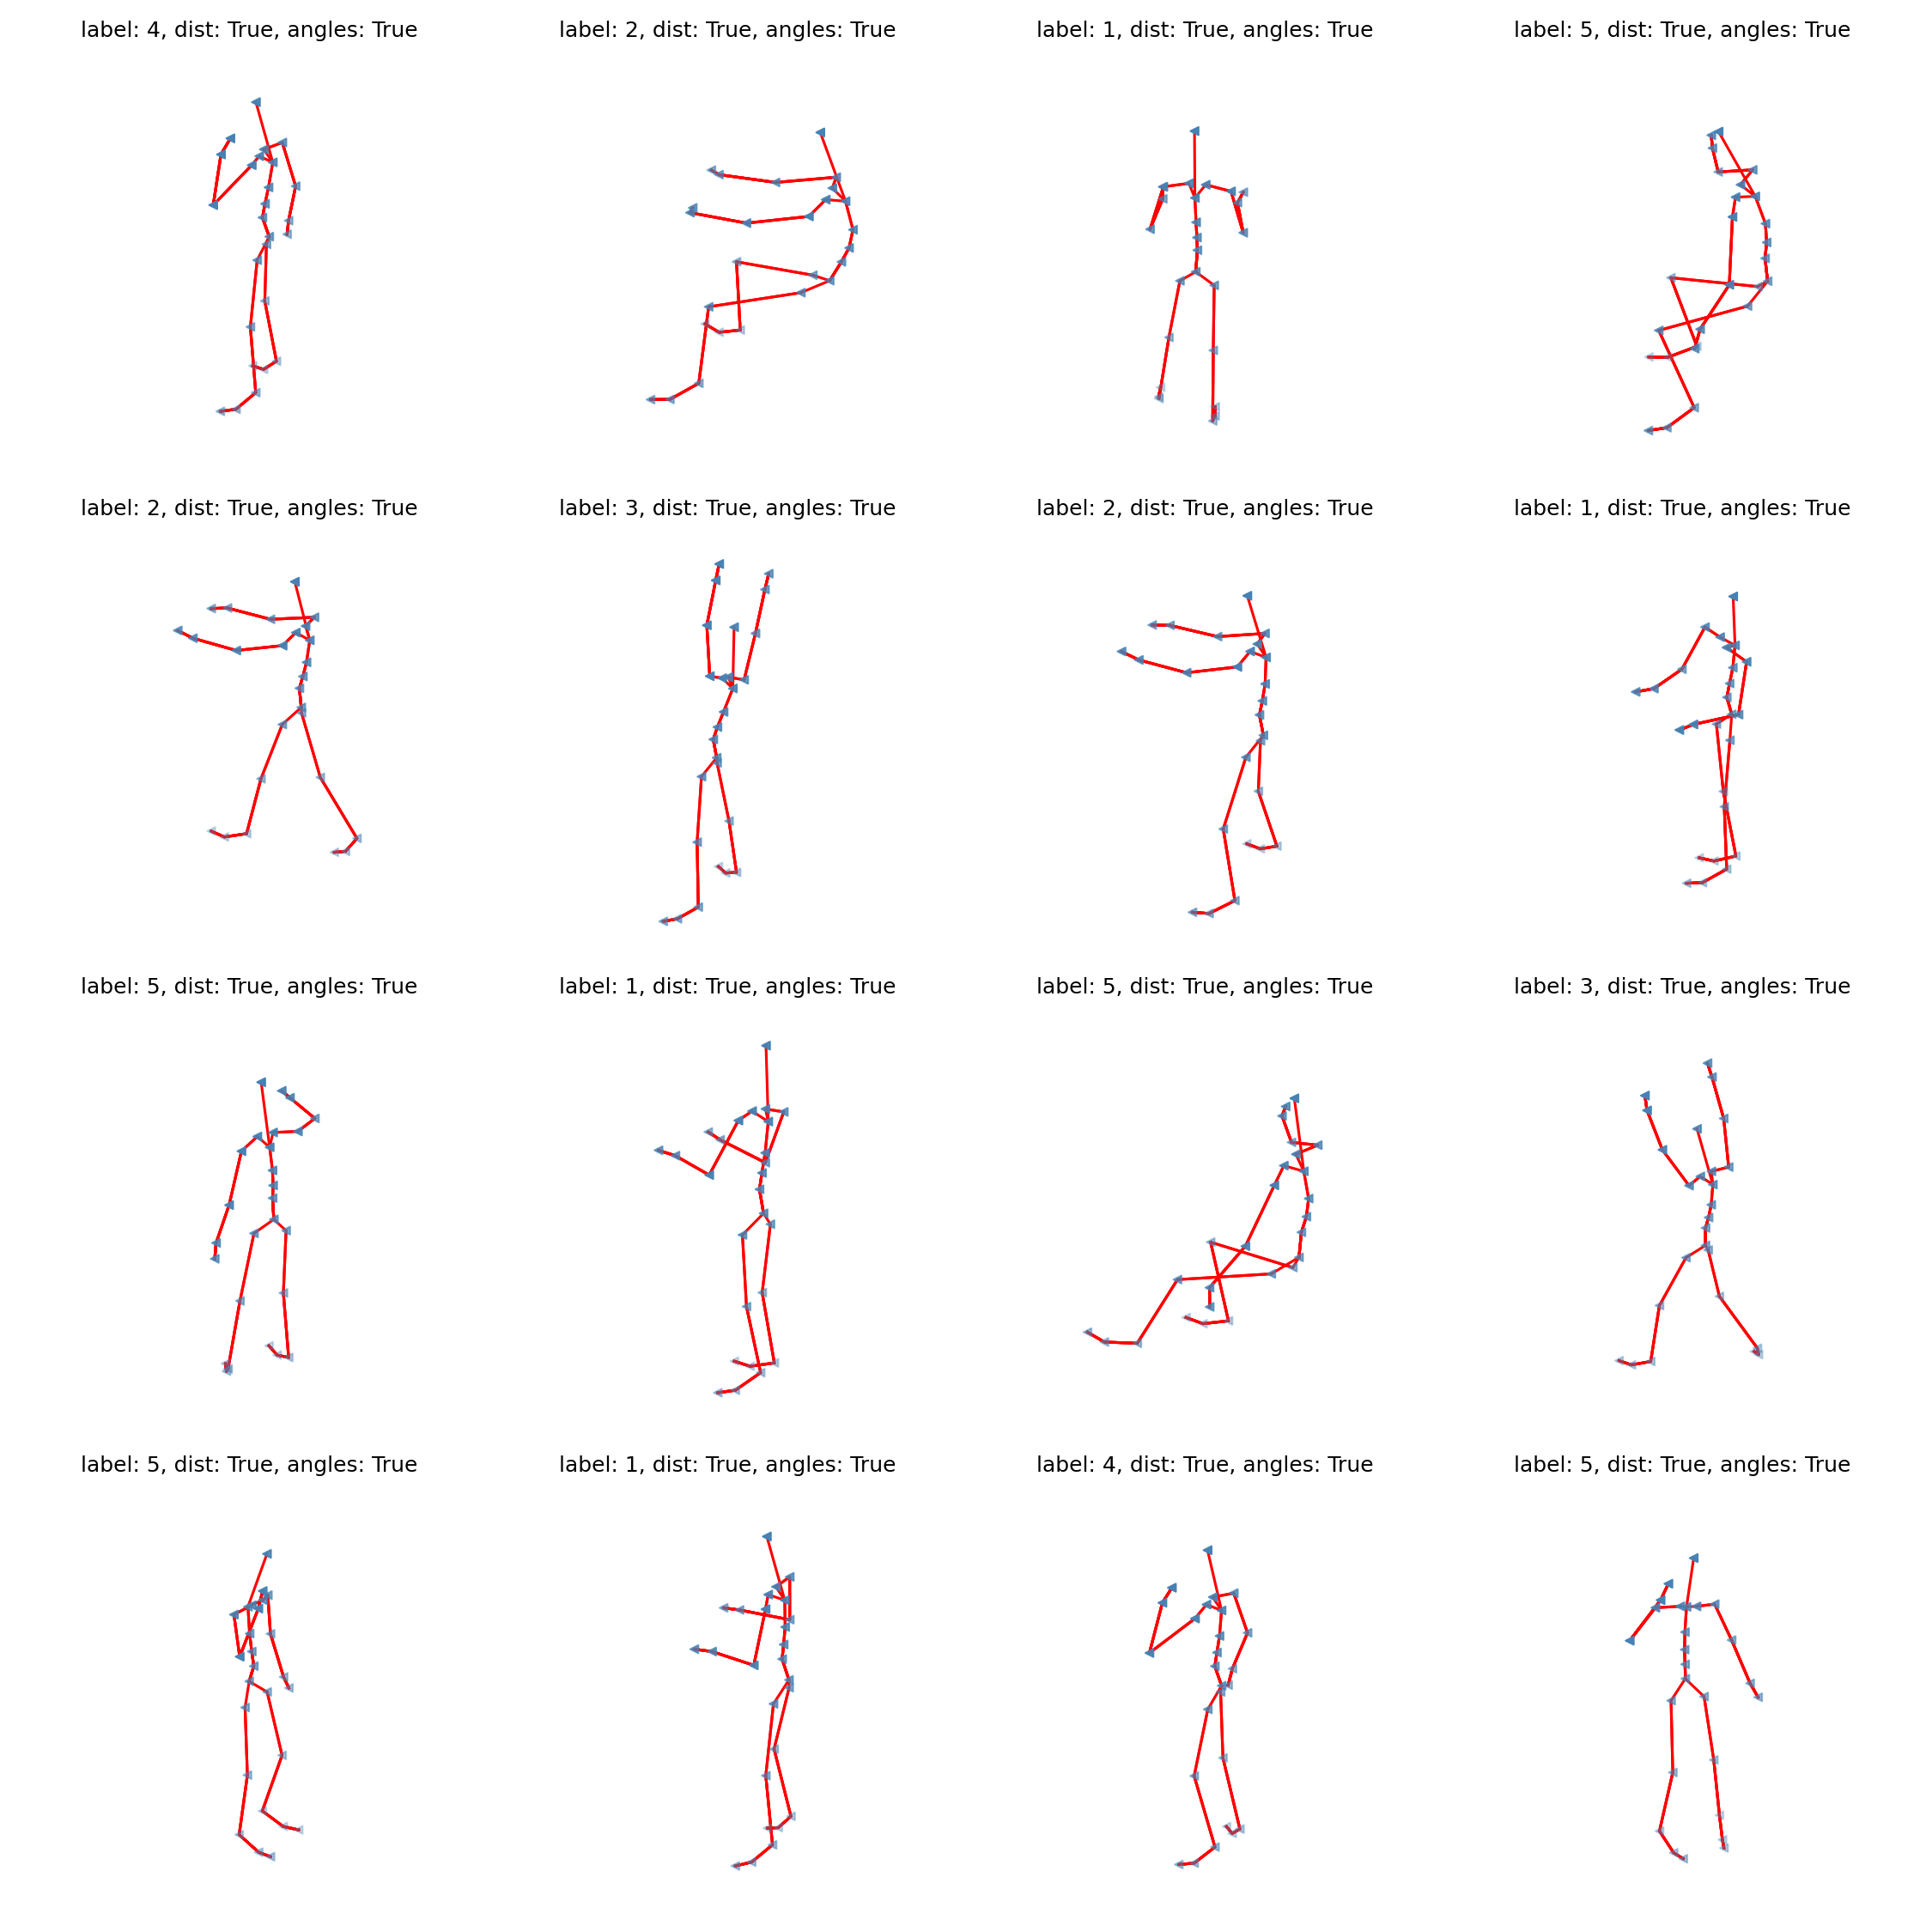

In [18]:
verification()

#### 6.3 Output dataset in .npy

In [11]:
output_dataset(output_npy=True)

type: <class 'numpy.ndarray'>, shape: (17000, 38)
type: <class 'numpy.ndarray'>, shape: (17000,)


#### 6.4 Verify .npy

x_data shape: (17000, 38)
y_data shape: (17000,)
skeletons shape: (17000, 3, 26)
These frames will be verified: [ 3349 16775 12446  6069  6654  5992  9117 16869  7139 16285  8295   805
 14544 12009  8324  1674]


<IPython.core.display.Javascript object>


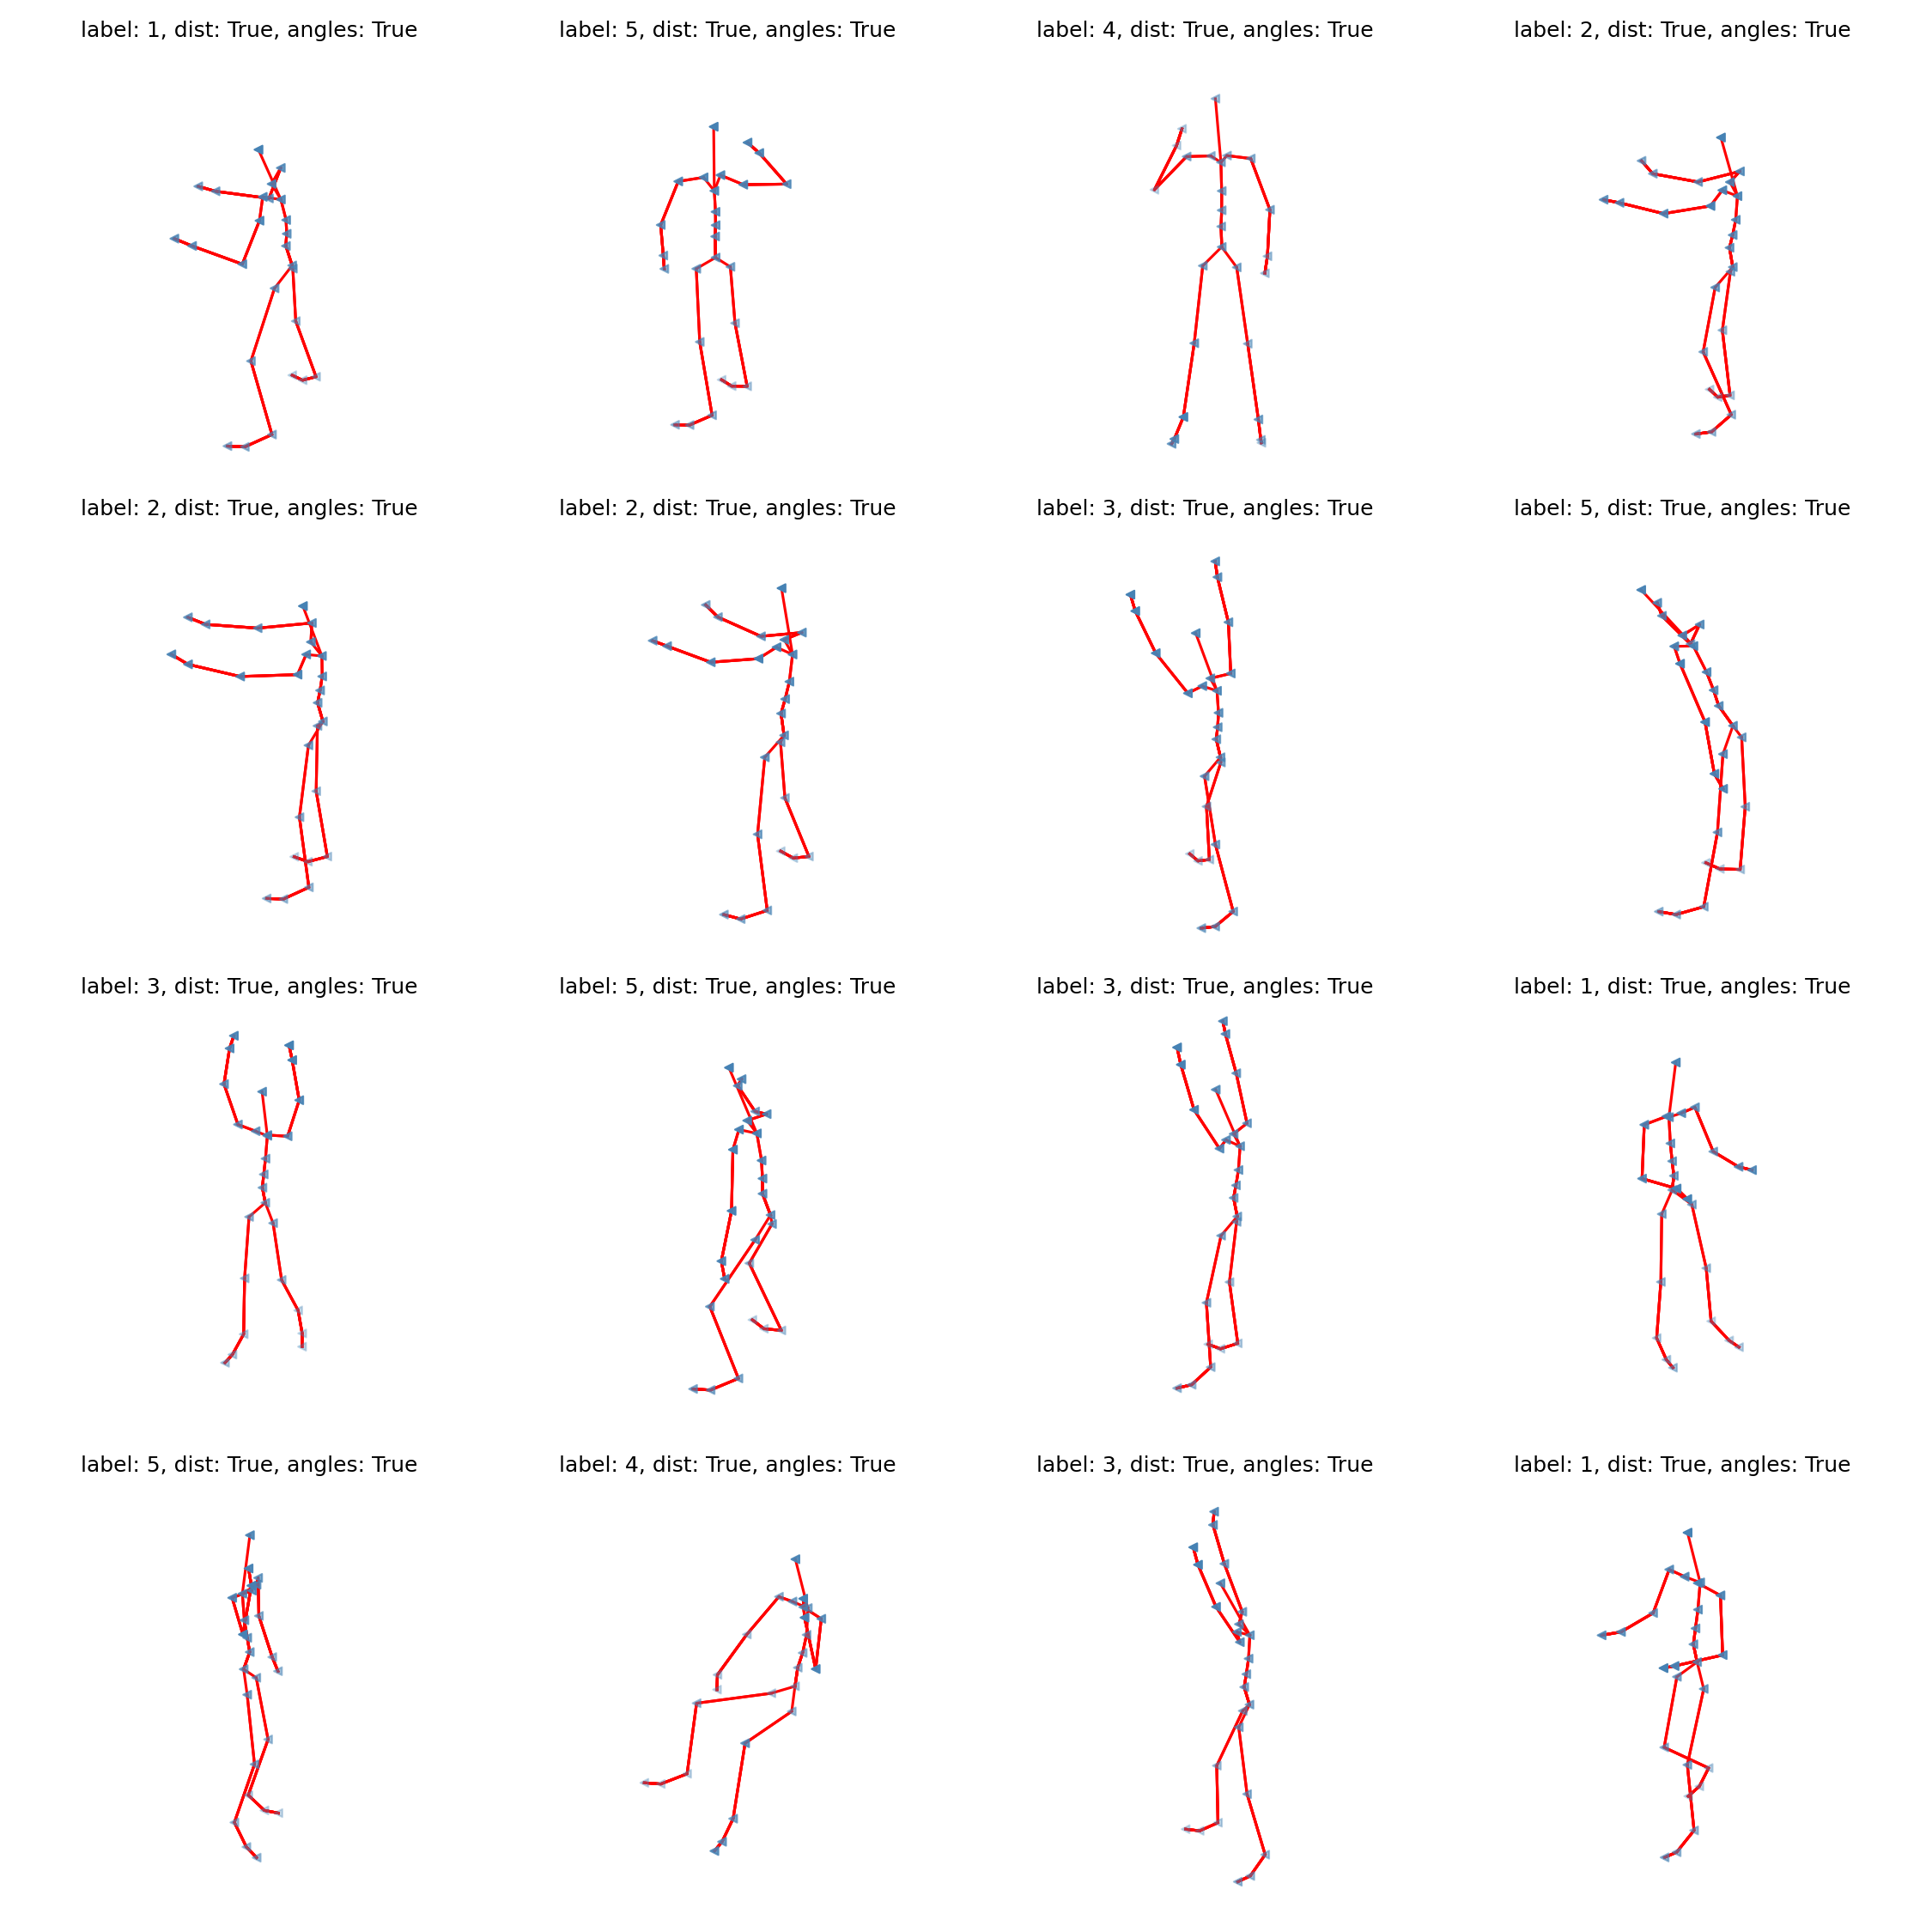

In [25]:
verification(dataset_path=['Dataset_Proposal/x_data.npy',
                           'Dataset_Proposal/y_data.npy'
                          ])